In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo, TimeDelta
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
client = makeEfdClient()

In [3]:
# Select data from a given date
dayObs = 20230626
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]


In [4]:
events[10]

dayObs: 20230626
seqNum: 10
type: SLEWING
endReason: STOPPED
duration: 129.63082265853882
begin: <Time object: scale='tai' format='unix_tai' value=1687823896.0061507>,
end: <Time object: scale='tai' format='unix_tai' value=1687824025.6369734>
beginFloat: 1687823896.0061507
endFloat: 1687824025.6369734


In [6]:
event_time=Time("2023-06-27 12:10:17.733")


In [51]:
getEfdData?

Signature:
getEfdData(
    client,
    topic,
    *,
    columns=None,
    prePadding=0,
    postPadding=0,
    dayObs=None,
    begin=None,
    end=None,
    timespan=None,
    event=None,
    expRecord=None,
    noWarn=False,
)
Docstring:
Get one or more EFD topics over a time range in a non-blocking manner.

The time range can be specified as either:
    * a dayObs, in which case the full 24 hour period is used,
    * a begin point and a end point,
    * a begin point and a timespan.
    * a mount event
    * an exposure record
If it is desired to use an end time with a timespan, just specify it as the
begin time and use a negative timespan.

The results from all topics are merged into a single dataframe.

Parameters
----------
client : `lsst_efd_client.efd_helper.EfdClient`
    The EFD client to use.
topic : `str`
    The topic to query.
columns : `list` of `str`, optional
    The columns to query. If not specified, all columns are queried.
prePadding : `float`
    The amount of ti

In [37]:
#df_mtmount_el_0=getEfdData(client,'lsst.sal.MTMount.elevation',  begin=event_time, end=event_time, prePadding=3, postPadding=4)

In [7]:
#df_mtmount_el_0=getEfdData(client,'lsst.sal.MTMount.elevation',  begin=event_time, end=event_time, prePadding=3, postPadding=4)
df_m1m3_hp_0=getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData",  
                        begin=event_time, 
                        end=event_time, 
                        prePadding=3, 
                        postPadding=4)

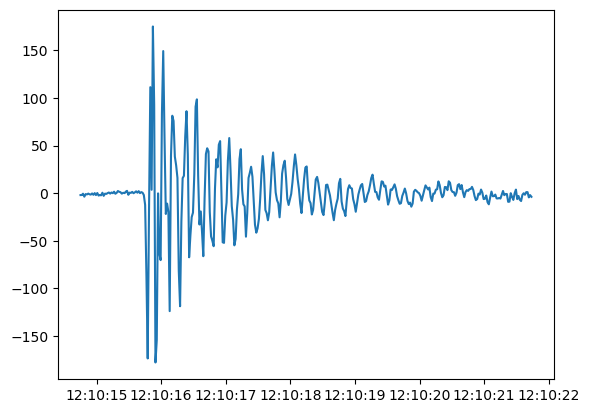

In [8]:
plt.plot(df_m1m3_hp_0.index,df_m1m3_hp_0["measuredForce0"])

In [9]:
df_mtmount_elevation=getEfdData(client,"lsst.sal.MTMount.elevation",  
                        event=slews[47], 
                        prePadding=3, 
                        postPadding=4)

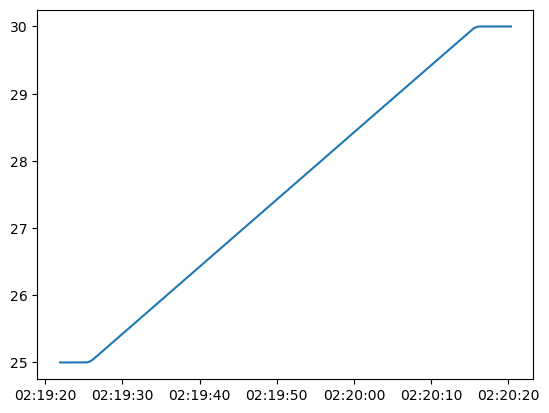

In [10]:
plt.plot(Time(df_mtmount_elevation.timestamp, format="unix_tai").datetime, df_mtmount_elevation["actualPosition"])

In [42]:
timestep=0.02
def get_freq_psd(vals,timestep):
    meanval=np.mean(vals)
    signal= vals - meanval
    N=len(signal)
    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2
    frequencies = np.fft.rfftfreq(N, timestep)
    return(frequencies, psd)

In [43]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [44]:
df_m1m3_ims_0=getEfdData(client,"lsst.sal.MTM1M3.imsData",  begin=event_time, end=event_time, prePadding=3, postPadding=4)
df_m1m3_ims_0=df_m1m3_ims_0.iloc[-400:,:]

Text(0.5, 0.98, 'decaying oscillation\nIMS')

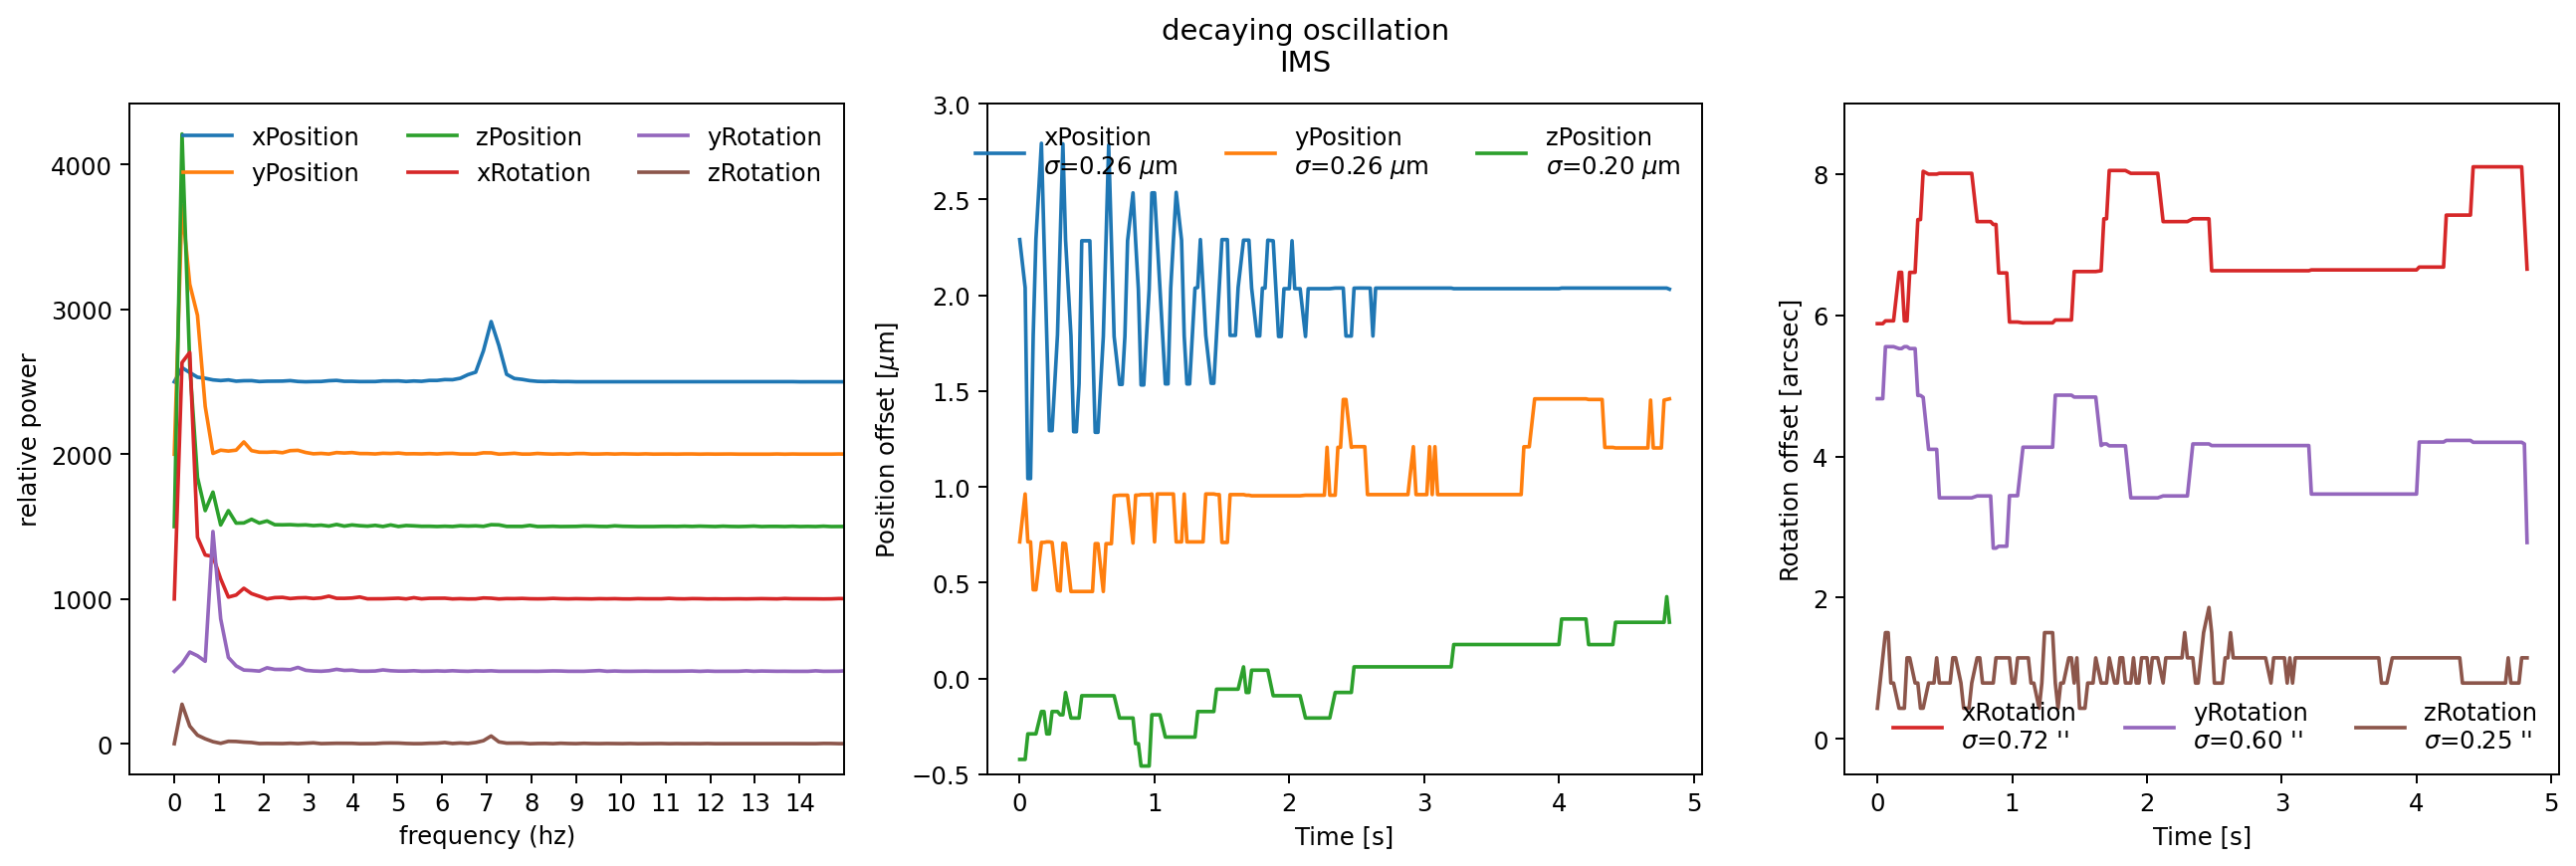

In [45]:
fig, axs=plt.subplots(1,3, dpi=175, figsize=(18,5))
ax=axs[0]
for i, column in enumerate(pos_columns + rot_columns):
    freq, psd = get_freq_psd(df_m1m3_ims_0[column], timestep)
    ax.plot(freq, psd/np.median(psd) - i * 500 + 2500, label=column)
ax.legend(ncol=3, edgecolor="None", facecolor="None")
#ax.set_ylim(-0.5,7)
ax.set_xlim(-1,15)
ax.set_xticks(np.arange(15))
ax.set_xlabel("frequency (hz)")
ax.set_ylabel("relative power")

ax=axs[1]
for i, column in enumerate(pos_columns):
    
    meanval=np.mean(df_m1m3_ims_0[column][-200:])
    times=Time(df_m1m3_ims_0["private_sndStamp"], format="unix_tai").unix
    ax.plot(times[-200:]-times[-200],
            (df_m1m3_ims_0[column][-200:]-meanval) * 1e6 - i + 2, 
            label=f"{column}\n$\sigma$={np.std(df_m1m3_ims_0[column][-200:])*1e6:0.2f} $\mu$m")
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-0.5,3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position offset [$\mu$m]")


ax=axs[2]
color_list=["tab:red","tab:purple","tab:brown"]
for i, column in enumerate(rot_columns):
    vals=np.rad2deg(df_m1m3_ims_0[column][-200:]) * 60 * 60
    meanval=np.mean(vals)
    times=Time(df_m1m3_ims_0["private_sndStamp"], format="unix_tai").unix
    ax.plot(times[-200:]-times[-200],
            (vals-meanval) - 3 * i + 7, c=color_list[i],
            label=f"{column}\n$\sigma$={np.std(vals):0.2f} '' ")
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-0.5,9)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Rotation offset [arcsec]")
plt.suptitle("decaying oscillation\nIMS")

In [46]:
#df_mtmount_el_0=getEfdData(client,'lsst.sal.MTMount.elevation',   event=slews[22], prePadding=15*60,postPadding=-5*60)
df_m1m3_hp_0=getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData",   event=slews[22], prePadding=15*60,postPadding=-5*60)



Text(0.5, 0.98, 'Decaying oscillation\nHardpoints')

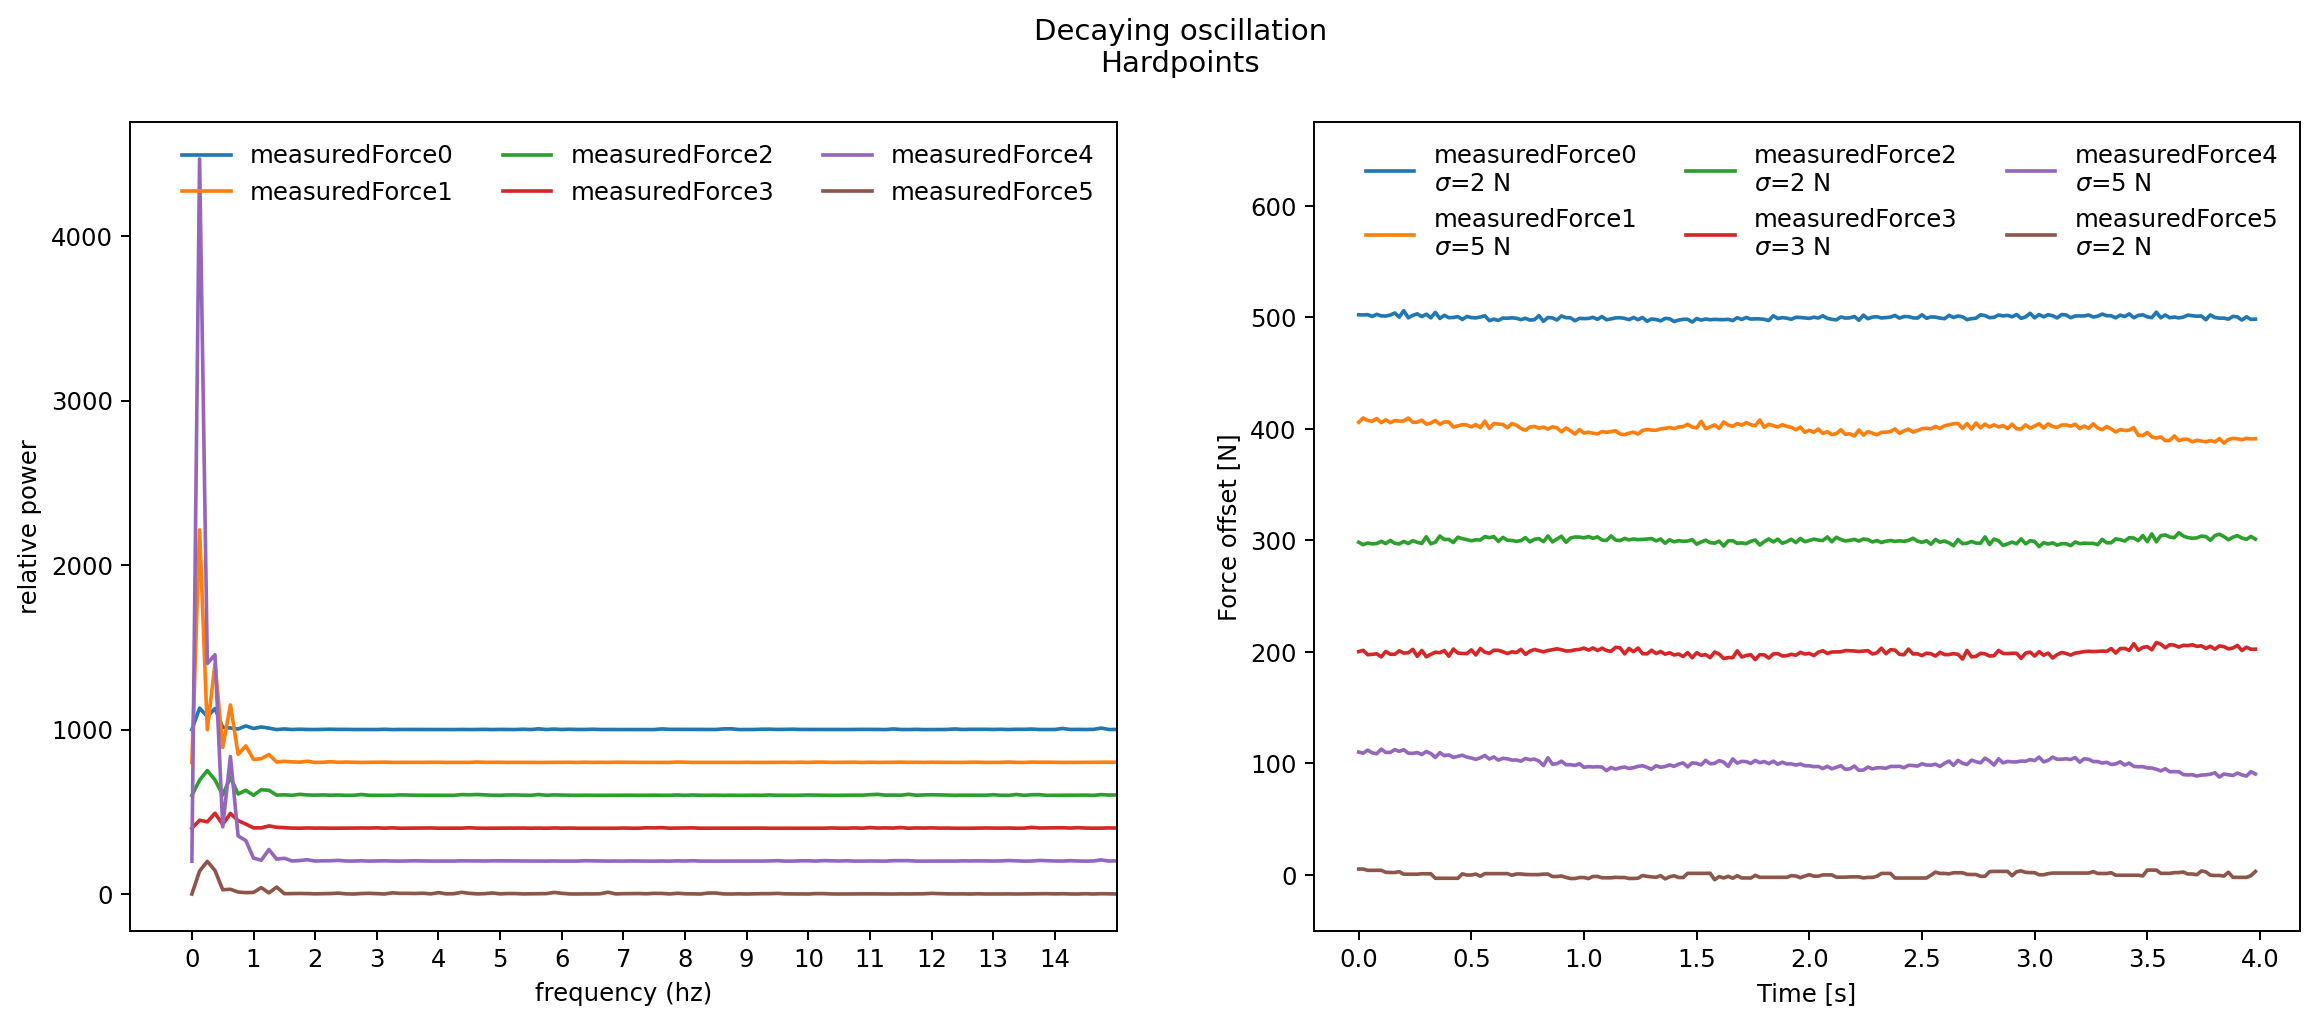

In [47]:
fig, axs=plt.subplots(1,2, dpi=175, figsize=(16,6))
ax=axs[0]
for i, column in enumerate(pos_columns + rot_columns):
    vals=df_m1m3_hp_0[f'measuredForce{i}'][-400:]
    freq, psd = get_freq_psd(vals-vals.mean(), timestep)
    ax.plot(freq, psd/np.median(psd) - i * 200 + 1000, label=f'measuredForce{i}')
ax.legend(ncol=3, edgecolor="None", facecolor="None")
#ax.set_ylim(-0.5,7)
ax.set_xlim(-1,15)
ax.set_xticks(np.arange(15))
ax.set_xlabel("frequency (hz)")
ax.set_ylabel("relative power")

ax=axs[1]
for i, column in enumerate(pos_columns + rot_columns):
    vals=df_m1m3_hp_0[f'measuredForce{i}'][-200:]
    times=Time(df_m1m3_hp_0["private_sndStamp"][-200:], format="unix_tai").unix
    ax.plot(times-times[0],
            (vals-vals.mean()) - i * 100 + 500, 
            label=f"measuredForce{i}\n"+f"$\sigma$={np.std(vals-vals.mean()):0.0f} N")
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-50, 675)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Force offset [N]")
plt.suptitle("Decaying oscillation\nHardpoints")
# for i in range(6):
#     ax=axs[i]
#     el_0=

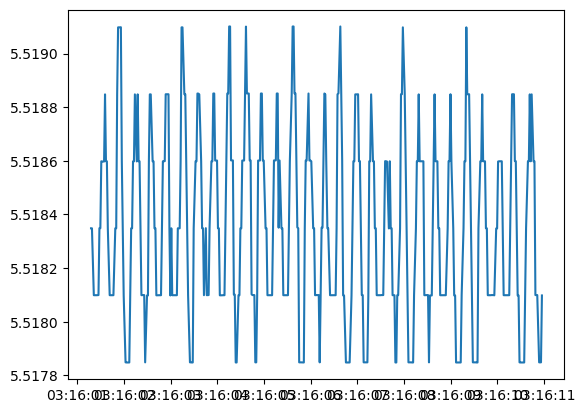

In [100]:
plt.plot(Time(df_m1m3_ims_0["private_sndStamp"],format="unix_tai").utc.datetime, df_m1m3_ims_0["yPosition"]*1e3)

In [103]:
np.median(df_m1m3_ims_0["private_sndStamp"][1:].values-df_m1m3_ims_0["private_sndStamp"][:-1].values)

0.020018577575683594